# Low-Surface Brightness Source Detection

<br>Owner: **Alex Drlica-Wagner** ([@kadrlica](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@kadrlica))
<br>Last Verified to Run: **2018-08-13**
<br>Verified Stack Release: **v16.0**

This Notebook demonstrates how to run the source detection, measurment, and deblending algorithms with a focus on optimizing for low-surface brightness object detection. It attempts to split out the source detection and measurement algorithms from `processCCD` and apply them to the search for low surface brightness galaxies. The content of this notebook builds off of an analysis from Johnny Greco, adapted into notebook form in Robert Lupton's [Greco LSB.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Greco%20LSB.ipynb). Some source detection and measurement details come from [Tune Detection.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Tune%20Detection.ipynb) and [Kron.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Kron.ipynb).
Interaction with `lsst.afw.display` was also improved by studying Michael Wood-Vasey's [DC2_Postage Stamps.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_postage_stamps.ipynb).

### Learning Objectives:
After working through and studying this notebook you should be able to
   1. Run the `lsst.meas.algorithm` source detection, deblending, and measurement tasks.
   2. Plot the resulting source catalogs and examine the mask of `DETECTED` pixels
   3. Remove detected sources at pixel level using the detected `FootprintSet`
   4. Re-run the source algorithms after convolving an image with a Gaussian kernel of a specific size.

Other techniques that are demonstrated, but not empasized, in this notebook are
   1. Use the `butler` to access a specific `calexp` `Exposure` object from Twinkles.
   2. Create an image cutout and use `lsst.afw.display` to plot it.
   3. Learn a bit about the [`matplotlib` backend to `lsst.afw.display` ](https://github.com/lsst/display_matplotlib/blob/master/python/lsst/display/matplotlib/matplotlib.py)

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


## Set Up

In [1]:
# What version of the Stack are we using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jld-lab-pjm43-r160
lsst_distrib          16.0+1     	current v16_0 setup


In [2]:
%matplotlib inline
#%matplotlib ipympl # currently slow, but may be a good option in the future
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown

from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval

In [3]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base        as dafBase

import lsst.afw.image       as afwImage
import lsst.afw.geom        as afwGeom
import lsst.afw.display     as afwDisplay
import lsst.afw.table       as afwTable

In [4]:
# Filter some warnings printed by v16.0 of the stack
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

zscale = ZScaleInterval()
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [5]:
# Position of our "ultra-diffuse galaxy"
x_target, y_target = 3835, 2380

# Position of our cutout
xmin,ymin = 3550,2100
width,height=400,400

### Data access

Here we use the `butler` to access a `calexp` from the Twinkles data subset. More information on the `butler` will be available in `Butler_Tutorial.ipynb` (TBD), while a deeper examination of the `calexp` object can be found in [Calexp_guided_tour.ipynb](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/Calexp_guided_tour.ipynb). We expect the user to have a working knowledge of these objects.

In [6]:
# The dafPersist was trying to set the matplotlib backend, catch warning
datadir = "/project/shared/data/Twinkles_subset/output_data_v2"
butler = dafPersist.Butler(datadir)

In [7]:
#For a list of available calexp exposures
#print(butler.queryMetadata('calexp', ['visit','raft','sensor']))

In [8]:
# Grab a calexp of interest
dataId = {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235}
calexp = butler.get('calexp', **dataId)

As described [elsewhere](), the `calexp` object possess more than just the raw pixel data of the image. It also contains a `mask`, which stores information about various pixels in a bit mask. Since we are interested in performing our own source detection and measurement, we choose to clear the previously set `DETECTED` mask plane.

In [9]:
# Unset the `DETECTED` bits of the mask plane
calexp.mask.removeAndClearMaskPlane('DETECTED')

(-0.5, 3999.5, -0.5, 4071.5)

<Figure size 576x576 with 0 Axes>

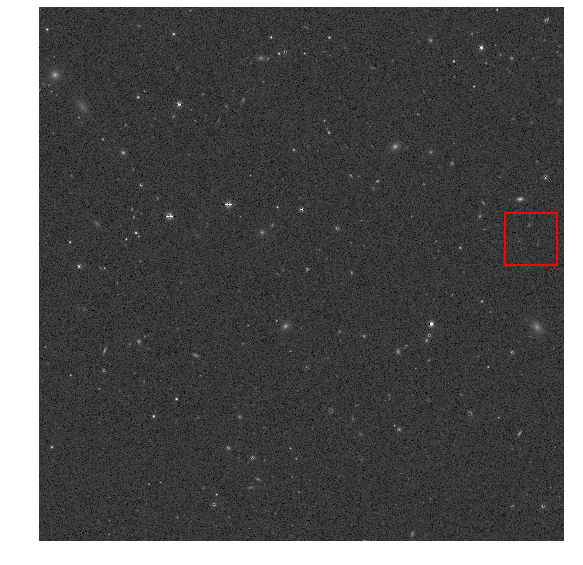

In [10]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib') 
# ADW: why can't we set the backend before this cell?

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.image)

# Overplot our cutout region of interest
rect = Rectangle((xmin,ymin),width,height,facecolor='none',edgecolor='r',lw=2)
plt.gca().add_artist(rect)
plt.gca().axis('off')

Our next step is to generate a cutout image. This is done by creating a bounding box and passing it to the `Factory` method of our calexp (a `lsst.afw.image.Exposure` object). Unfortunately, the arguments for the `Factory` method are poorly documented, and below we explain the specific arguments that we are passing to `Factory`:
```
calexp: the ExposureF we are starting from
bbox : the bounding box of the cutout
origin : the image pixel origin is local to the cutout array
deep : copy the data rather than passing by reference
```

In [11]:
# Define a small region for a cutout
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(xmin, ymin))
bbox.include(afwGeom.Point2I(xmin+width, ymin+height))

# Generate the cutout image
cutout = calexp.Factory(calexp, bbox, origin=afwImage.LOCAL, deep=False)

<Figure size 576x576 with 0 Axes>

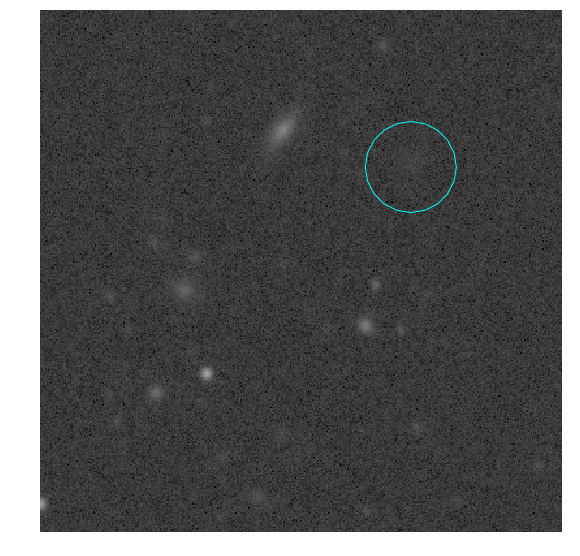

In [12]:
# Follow the same procedure as before to plot the cutout
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout.image)
plt.gca().axis('off')

# Plot the location of our target galaxy
afw_display.dot('o', x_target, y_target, size=35, ctype='cyan')

Ok, even for us this may be a little faint. Let's add a few more photons to this source. We generate a list of additional photons from a 2D Gaussian and add them to the pixel values of the image array.

In [13]:
# Generate a list of photons with random pixel coordinates drawn from a 2D Gaussian
nphotons = int(2e4) # 20k photons
sigma = 250         # Gaussian sigma in pix
cov = [[sigma,sigma/2],[sigma/2,sigma]] # covariance (give the source some ellipticity)
xidx,yidx = np.random.multivariate_normal((x_target,y_target),cov,size=nphotons).astype(int).T
np.add.at(calexp.image.array, [yidx,xidx], 1)

<Figure size 576x576 with 0 Axes>

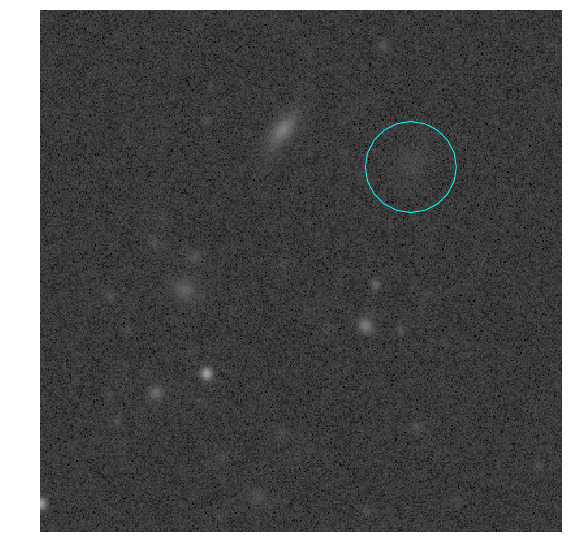

In [14]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout.image)
plt.gca().axis('off')

# Plot the location of our target galaxy
afw_display.dot('o', x_target, y_target, size=35, ctype='cyan')

# Source Detection, Deblending, and Measurement

We now want to run the LSST source detection, deblending, and measurement tasks. While we run all three tasks, this notebook is mostly focused on the detection of faint sources.

In [15]:
# Importing the tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate         import CalibrateTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

Each task possesses an associated configuration class. The properties of these classes can be determined from the classes themselves.

In [16]:
# Uncomment the following line to view help on the CharacterizeImageTask configuration
#help(CharacterizeImageTask.ConfigClass())

In [17]:
# Create the Tasks
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask = CharacterizeImageTask(None, config=config)

config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10       # detection threshold in units of thresholdType
config.thresholdType = "stdev"   # units for thresholdValue

sourceDetectionTask =   SourceDetectionTask(schema=schema, config=config)
sourceDeblendTask   =   SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                   algMetadata=algMetadata)

With the each of the tasks configured, we can now move on to running the source detection, deblending, and measurement. Like the configs, we can use `help` to explore each task and the methods used to run it.

First we create `SourceTable` for holding the output of our source analysis. The columns and characteristics of this table are defined by the `schema` that we created in our configuration step.

In [18]:
tab = afwTable.SourceTable.make(schema)

Next we characterize our image. This calculates various global properties, such as the PSF FWHM.

In [19]:
# Image characterization (this cell may take a few seconds)
result = charImageTask.characterize(calexp)

psf = calexp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()
pixelScale = calexp.getWcs().getPixelScale().asArcseconds()
print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))

psf fwhm = 1.05 arcsec


With the image characterized, we are now interested in running the source detection, deblending, and measurement tasks. Each of these tasks is called with the `run` method. The parameters of this method can be investigated using `help`.

In [20]:
# We are specifically interested in the `SourceMeasurementTask`
#help(sourceMeasurementTask.run)

In [21]:
# Source detection (this cell may take a few seconds)
result = sourceDetectionTask.run(tab, calexp)
type(result)

lsst.pipe.base.struct.Struct

The source detection tasks returns an [`lsst.pipe.base.struct.Struct`](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1pipe_1_1base_1_1struct_1_1_struct.html). A `Struct` is just a generalized container for storing multiple output components and accessessing them as attributes. The content of this `Struct` can be investigated with the `getDict` method.

In [22]:
for k,v in result.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection._footprintSet.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
background <class 'lsst.afw.math.backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
fpSets <class 'lsst.pipe.base.struct.Struct'>
sources <class 'lsst.afw.table.source.source.SourceCatalog'>


The members of the `Struct` can be accessed either through dictionary keys or as attributes of the `Struct`. For example:

In [23]:
sources = result.sources
fpsets  = result.getDict()['fpSets']

Note that `sources` is a `SourceCatalog` while `fpSets` is a `Struct` of it's own. Some algorithms can take these objects as they are, while others will require us to massage them a bit. Note that if we desire we can save some of these processed objects to disk.

In [24]:
if False:
    sources.writeFits("outputTable.fits")
    calexp.writeFits("example1-out.fits")

Next we run the `SourceDeblendTask` and `SingleFrameMeasurementTask`. A deeper investigation of these tasks is beyond the scope of this notebook.

In [25]:
# Source deblending
sourceDeblendTask.run(calexp, sources)

# Source measurement (catch future warning about machine precision)
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

To get a better look at the output sources, we need to make sure that the `SourceCatalog` is contiguous in memory. Converting to an `astropy` table provides a human-readable output format. A deeper dive into `SourceCatalog`s is beyond the scope of this notebook.

In [26]:
# ADW: Why do we `copy` the sources? This seems like a poorly named method...
sources = sources.copy(True)

# Investigate the output source catalog
sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xSigma,slot_Centroid_xSigma,base_SdssCentroid_ySigma,slot_Centroid_ySigma,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_Blendedness_old,base_Blendedness_raw_flux,base_Blendedness_raw_flux_child,base_Blendedness_raw_flux_parent,base_Blendedness_abs_flux,base_Blendedness_abs_flux_child,base_Blendedness_abs_flux_parent,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blendedness_flag_noCentroid,base_Blendedness_flag_noShape,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxSigma,slot_Shape_xxSigma,base_SdssShape_yySigma,slot_Shape_yySigma,base_SdssShape_xySigma,slot_Shape_xySigma,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_flux,slot_Shape_flux,base_S

We can now overplot our detected sources on the calexp or cutout image using `afwDisplay`.

<a id='display-error'></a>

<Figure size 576x576 with 0 Axes>

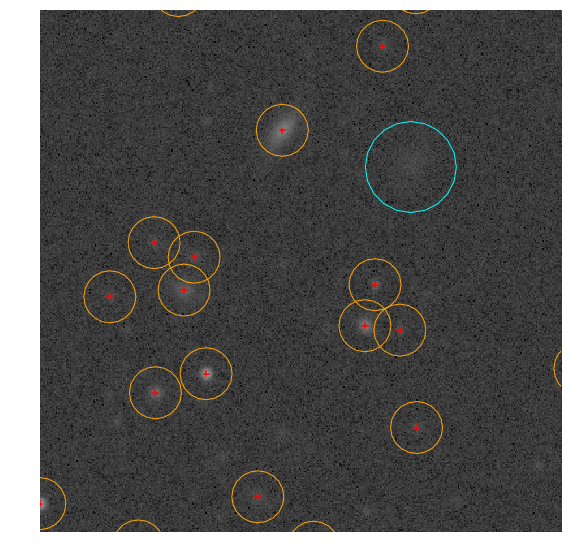

In [27]:
#Display the cutout and sources with afw display
image = cutout.image
#image = calexp.image

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(image)
plt.gca().axis('off')

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    for s in sources:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange')   

        #ADW: This should work, but doesn't?
        #https://github.com/lsst/display_matplotlib/pull/6
        #afw_display.dot(s.getShape(), s.getX(), s.getY(), size=35, ctype='orange')
    # Our "ultra-faint galaxy" (e.g. smudge)
    afw_display.dot('o', x_target, y_target, size=35, ctype='cyan')

Clearly our default settings for the source detection are missing our faint smudge. Let's see what we can do to improve this. 

### Faint Source Detection

Our goal now is to improve the detection of faint, low-surface brightness sources in our images. Our plan of attack is to subtract the bright sources that have already been detected, and then convlve the residual image with a large spatial kernel. Our hope is that this will increase the contrast for our faint target.

We start by identifying the pixels that are associated with the sources that we detected. This information is contained in the mask plane of our calexp and can be visualized with the `MaskedImage` object. 

(3549.5, 3950.5, 2099.5, 2500.5)

<Figure size 576x576 with 0 Axes>

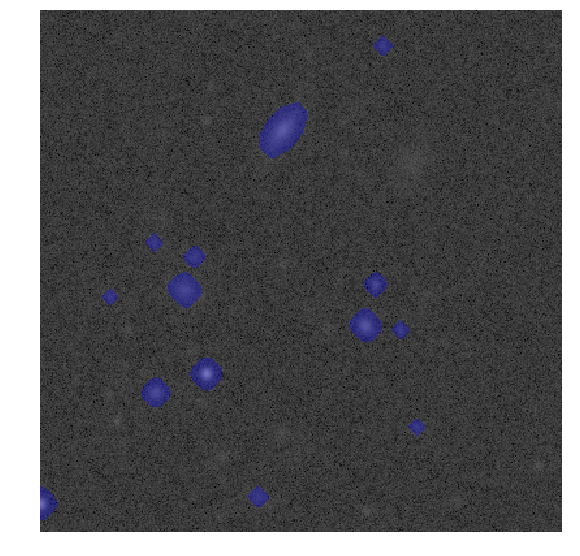

In [28]:
image = cutout.getMaskedImage()   #plot the cutout
#image = calexp.getMaskedImage()   #plot the calexp

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(image)
plt.gca().axis('off')

The `MaskedImage` is overplotting the values of the mask plane. The mapping between mask color and mask bit can be queried directly from the mask object.

In [29]:
for maskName, maskBit in cutout.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))

red: BAD
magenta: CR
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
green: INTRP
orange: NO_DATA
None: OTHERDET
green: SAT
yellow: SUSPECT
None: THISDET


We now want to make a copy of our calexp and cutout so that we remove the detected sources. The way we do this is by replacing the values of `DETECTED` pixels with the characteristic noise estimated from the exposure.

In [30]:
# Create a deep copy of the calexp, along with a MaskedImage and Mask
calexp_clean = calexp.clone()
mimage_clean = calexp_clean.getMaskedImage()
mask_clean = calexp_clean.getMask()

# Create a noise array from the standard deviation of the unmasked pixel values
back_rms = mimage_clean.image.array[mask_clean.array==0].std()
noise_array = back_rms*np.random.randn(*mask_clean.array.shape)

# Create a boolean mask of pixels to replace
replace = mask_clean.array & mask_clean.getPlaneBitMask('DETECTED') != 0

# Replace the values of DETECTED pixels with the noise array value
mimage_clean.image.array[replace] = noise_array[replace]

# Create a cleaned cutout from the cleaned calexp
cutout_clean = calexp_clean.Factory(calexp_clean, bbox, origin=afwImage.LOCAL, deep=False)

(3549.5, 3950.5, 2099.5, 2500.5)

<Figure size 576x576 with 0 Axes>

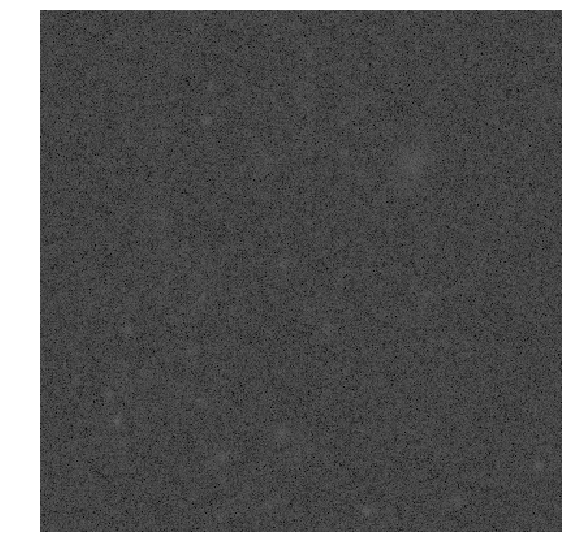

In [31]:
image = cutout_clean.image
#image = calexp_clean.image # uncomment to plot full calexp instead

plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(image)
plt.gca().axis('off')

The procedure above masks all `DETECTED` pixels with a simplistic selection. However, the Stack provides an alternative mechanism for more directed masking through the [meas.base.noiseReplacer](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1meas_1_1base_1_1noise_replacer_1_1_noise_replacer.html). The `noiseReplacer` takes as input the calexp object and the footprint set (`fpset`) returned `sourceDetectionTask`. With the `noiseReplacer`, it is possible to selectively replace a subset of the sources.

Now let's try re-running the source detection task with a larger convolution kernel. To figure out how to do this, we take a dive into the SourceDetectionTask and it's associated `SourceDetectionConfig`.

In [32]:
print(SourceDetectionTask)
print(SourceDetectionTask.ConfigClass)

<class 'lsst.meas.algorithms.detection.SourceDetectionTask'>
<class 'lsst.meas.algorithms.detection.SourceDetectionConfig'>


So `SourceDetectionTask` lives in [lsst.meas.algorithms.detection](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1meas_1_1algorithms_1_1detection_1_1_source_detection_task.html), where we can find a link to documentation for the associated [SourceDetectionConfig](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1meas_1_1algorithms_1_1detection_1_1_source_detection_config.html). The [source code](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/detection_8py_source.html) will help us understand what `SourceDetectionTask` is doing.

Specifically, we are interested in adjusting the PSF size for `SourceDetectionTask.run`. To see the impact that this will have on the search image, we [dive into the source code](https://github.com/lsst/meas_algorithms/blob/e62bbd2ae2268e5ef5ef4ad8e0e60bf159c01190/python/lsst/meas/algorithms/detection.py#L752-L756) to extract the convolution step.

```
        psf = self.getPsf(exposure, sigma=sigma)
        with self.tempWideBackgroundContext(exposure):
            convolveResults = self.convolveImage(maskedImage, psf, doSmooth=doSmooth)
            middle = convolveResults.middle
            sigma = convolveResults.sigma

```

We don't know a priori the size of the convolution kernel that will maximize the signal-to-noise of our faint source, so we do a little visual investigation on the cleaned cutout.

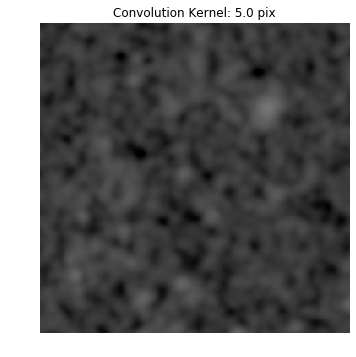

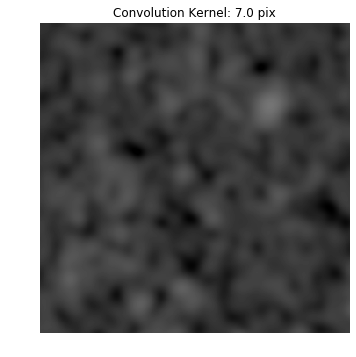

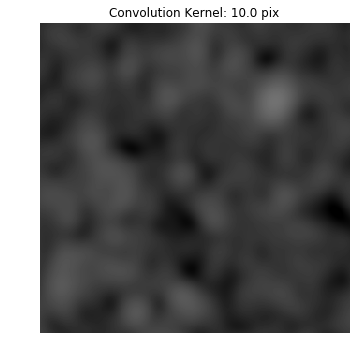

In [33]:
doSmooth = True # actually do the smoothing

# Loop over PSF convolution size in pixels
for i,sigma in enumerate([5, 7, 10]):
    # Make a deep copy of the cutout
    exp = cutout_clean.clone()
    # Alternatively we can see what happens to the full calexp
    #exp = calexp.clone()
    
    psf = sourceDetectionTask.getPsf(exp, sigma=sigma)
    convolveResults = sourceDetectionTask.convolveImage(exp.getMaskedImage(), psf, doSmooth=doSmooth)
    middle = convolveResults.middle
    sigma = convolveResults.sigma

    plt.figure(i, figsize=(5,5))
    afw_display = afwDisplay.Display(frame=i)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(middle.image)
    plt.gca().axis('off')
    plt.title("Convolution Kernel: %s pix"%sigma)

It looks like a convolution kernel of 7 pix does good enough at increasing the contrast for our source. We can re-run the source detection, deblending, and measurement tasks. When running the `SourceDetectionTask` we explicitly set `sigma = 7`

In [34]:
# Run source detection, deblending, and measurement (this cell may take a few seconds)
tab = afwTable.SourceTable.make(schema)

# Source detection
result = sourceDetectionTask.run(tab, calexp_clean, sigma=7)
sources = result.sources

# Source deblending
sourceDeblendTask.run(calexp_clean, sources)
# Source measurement (catch future warning about machine precision)
sourceMeasurementTask.run(measCat=sources, exposure=calexp_clean)

# Make sure sources are contiguous in memory
sources = sources.copy(True)

In [35]:
# Investigate the output source catalog
sources.asAstropy()

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xSigma,slot_Centroid_xSigma,base_SdssCentroid_ySigma,slot_Centroid_ySigma,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_Blendedness_old,base_Blendedness_raw_flux,base_Blendedness_raw_flux_child,base_Blendedness_raw_flux_parent,base_Blendedness_abs_flux,base_Blendedness_abs_flux_child,base_Blendedness_abs_flux_parent,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_Blendedness_flag,base_Blendedness_flag_noCentroid,base_Blendedness_flag_noShape,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxSigma,slot_Shape_xxSigma,base_SdssShape_yySigma,slot_Shape_yySigma,base_SdssShape_xySigma,slot_Shape_xySigma,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_flux,slot_Shape_flux,base_S

<Figure size 576x576 with 0 Axes>

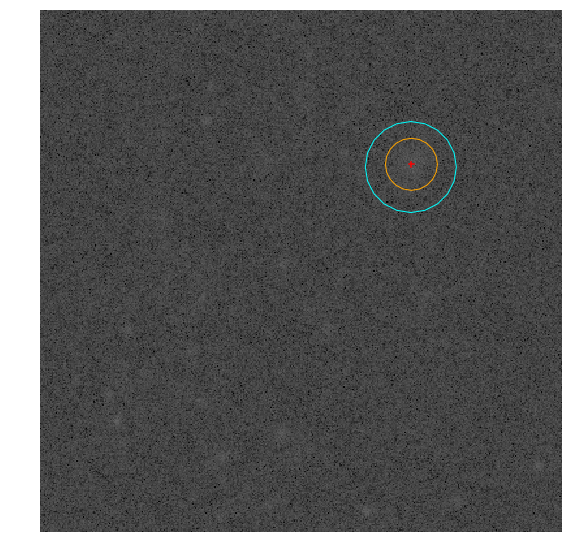

In [36]:
#Display the cutout and detected sources with afw display
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout_clean.image)
plt.gca().axis('off')

with afw_display.Buffering():
    for s in sources:
        afw_display.dot('+', *s.getCentroid(), ctype=afwDisplay.RED)
        afw_display.dot('o', s.getX(), s.getY(), size=20, ctype='orange')   

    # Our "ultra-faint galaxy" (e.g. smudge)
    afw_display.dot('o', x_target, y_target, size=35, ctype='cyan')

Success! We've been able to pick up our faint smudge! Now good luck measuring the distance to that sucker!

# Summary

In this tutorial, you should have learned how to access a calexp, make a cutout, configure the source detection, subtract detected sources, convolve the image with a fixed kernel, and re-extract a faint, low-surface brightness source.